**The task here is to predict customers who will deafult on loan payment**

## Import required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "drive/My Drive/DSN AI Bootcamp"

/content/drive/My Drive/DSN AI Bootcamp


In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 101kB/s 


In [26]:
!pip install ppscore

  Created wheel for ppscore: filename=ppscore-1.1.1-py2.py3-none-any.whl size=12987 sha256=c5b6d5f4fa7818fa99942d18ab4dec559ebe20e775a10238e92ffa86609ba150
  Stored in directory: /root/.cache/pip/wheels/3a/16/cb/4768ae3fd9f02af8cd6d880b9095281cc62bb1748fac67fdc4
Successfully built ppscore


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgbst
import catboost as catbst
import seaborn as sns
import lightgbm as lgb
import ppscore as pps
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Read in dataset

In [28]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
subm = pd.read_csv('SampleSubmission.csv')

# Feature Engineering and correlation check

In [29]:
df_test['default_status'] = 'test'
data = pd.concat([df_train, df_test]).reset_index(drop = True)
data['form_field47'] = data['form_field47'].factorize()[0]
data = data.fillna(-9999999)
data = data.drop(['Applicant_ID'] , axis = 1)

In [30]:
def heatmap(df):
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title("PPS matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    return ax

matrix = pps.matrix(data)

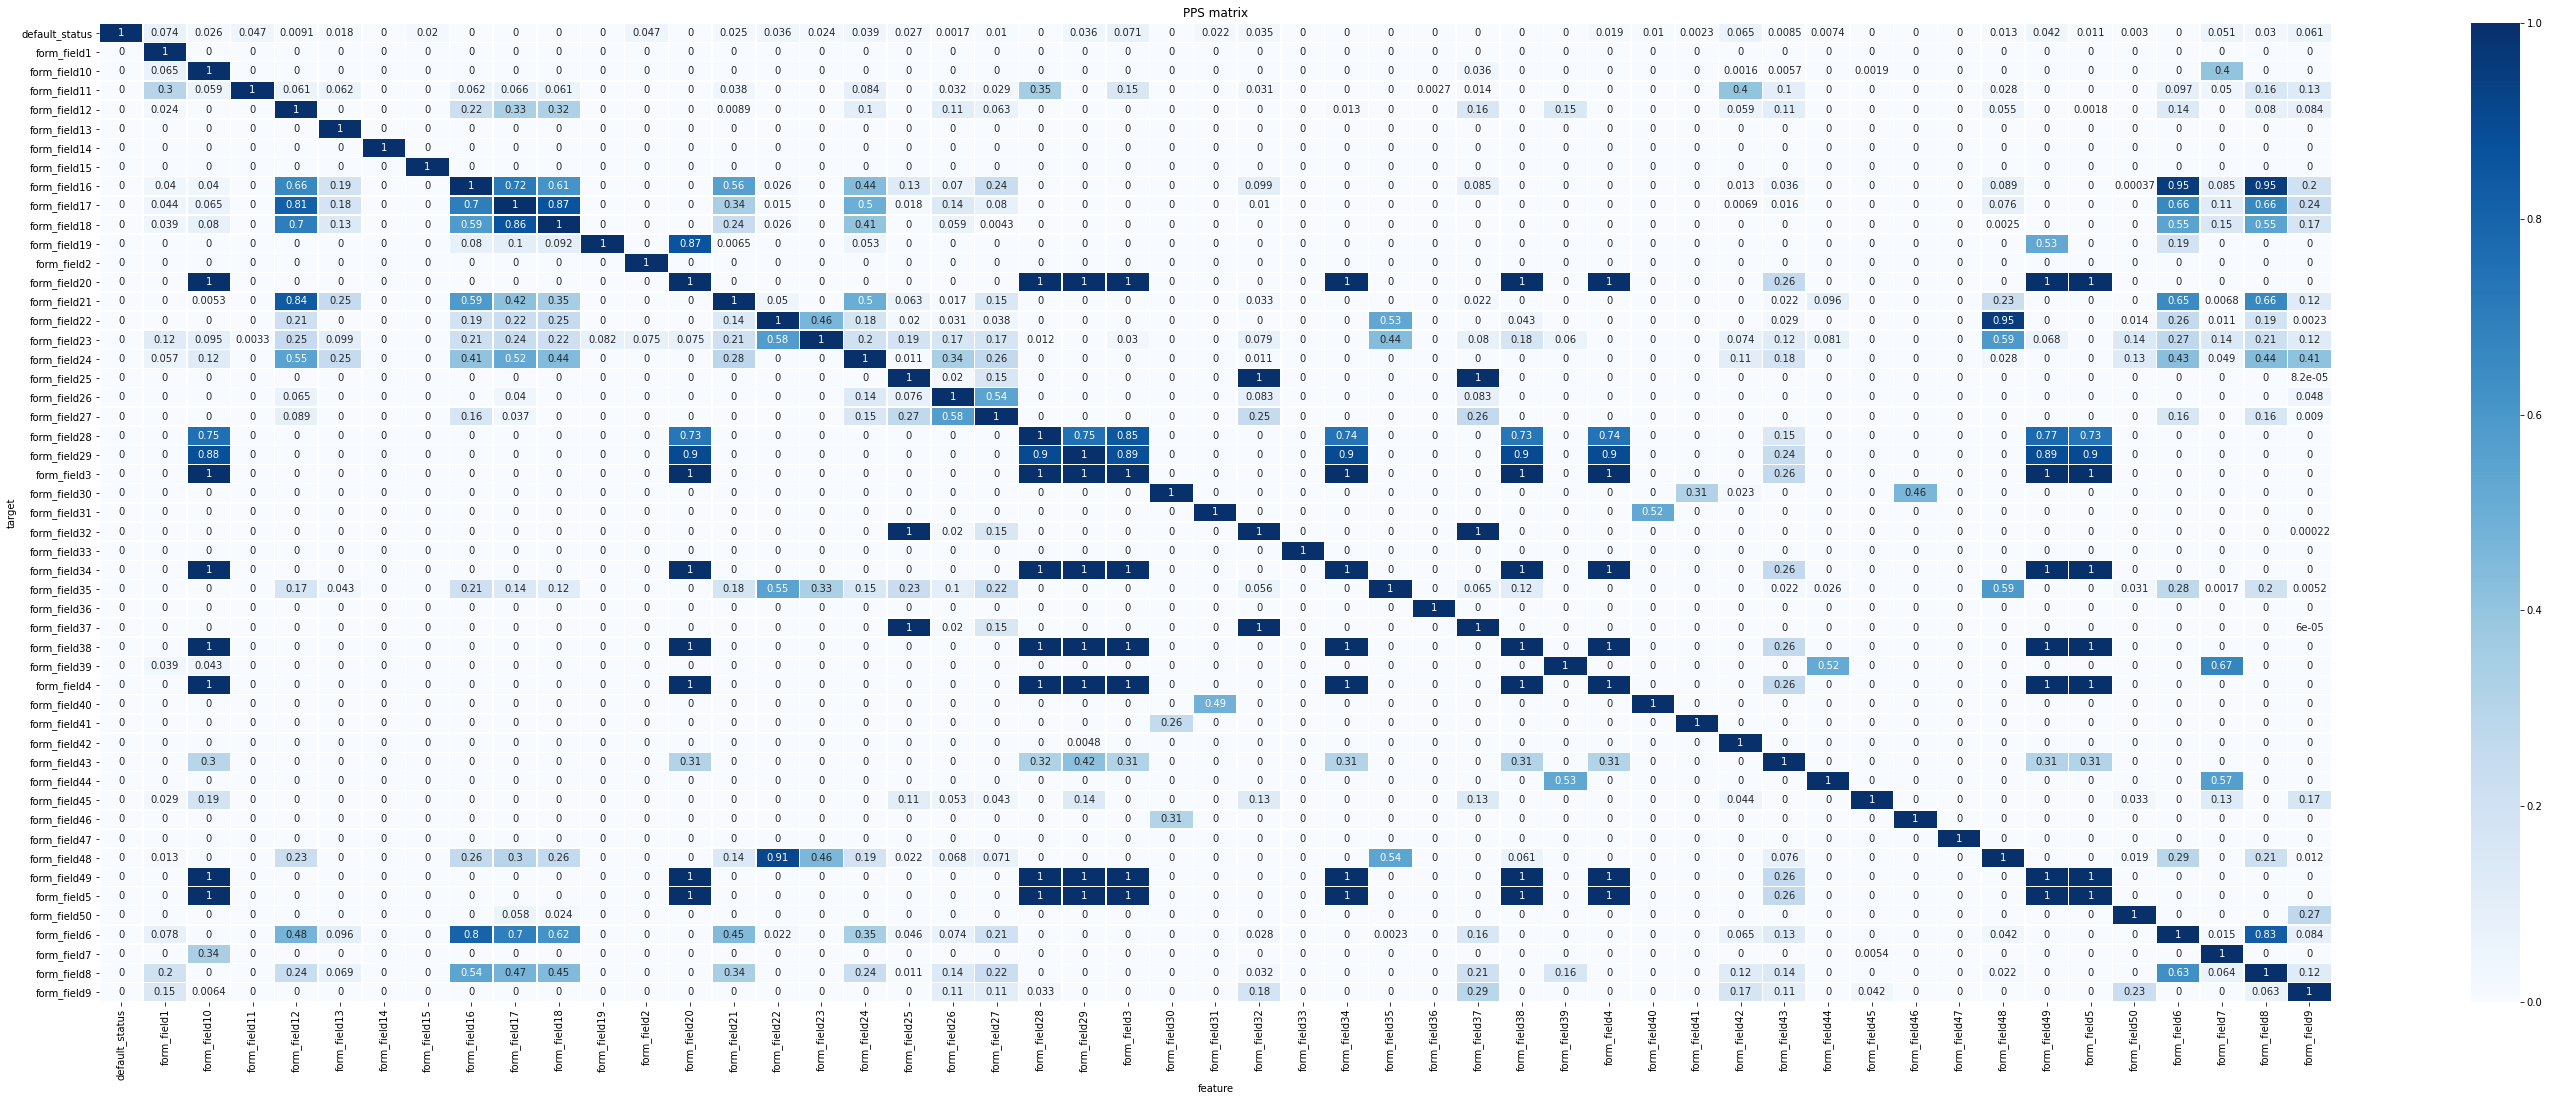

In [31]:
plt.figure(figsize=(50,18))
heatmap(matrix)

In [ ]:
data['avg_1'] = (data['form_field6'] + data['form_field8'])/2
data['owe'] = data['form_field14'] - data['form_field12']
data['owe_2'] = data['form_field13'] - data['form_field12']
data['tot_loans'] = data['form_field45'] + data['form_field46']
data['tot_utz'] = data['form_field40'] + data['form_field41']
data['max_ten'] = data['form_field30'] + data['form_field31']

In [ ]:
cols = data.columns.difference(['default_status'])

for col in cols:
    data[col +'_type.mean'] = data[col].groupby(data['form_field47']).transform('mean')
    data[col +'_type.sum'] = data[col].groupby(data['form_field47']).transform('sum')


In [ ]:
col_1 = data.columns.difference(['default_status'])
for col in col_1:
    data[col] = data[col].astype('float')

In [ ]:
test = data[data['default_status'] == 'test']
train = data[data['default_status'] != 'test']
train['default_status'] = train['default_status'].factorize()[0]
test = test.drop(['default_status'], axis = 1)

In [ ]:
X_train = train.drop(['default_status'], axis = 1)
y_train = train['default_status']

In [ ]:
cols = data.columns.difference(['default_status'])
cols

In [ ]:
train = X_train.copy()
target = y_train.copy()

# Creating an helper function for easy training and validation

In [ ]:
class help_func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'rtf'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.valid_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict
        
        def rtf_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.valid_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict
        

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = 50)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.valid_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = 50)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.valid_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.valid_p = np.zeros(self.train.shape[0])
        mean_valid = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 10
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rtf': x_test_predict, x_train_predict = rtf_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_valid.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_valid), np.mean(mean_train), np.std(mean_valid))
        return self.valid_p, self.test_p/splits, self.model

## Training the models...

In [ ]:
catboost = catbst.CatBoostClassifier(n_estimators=4015,rsm = 0.5, max_depth= 10, learning_rate = 0.005, reg_lambda = 3, devices='0:1')

run_1 = help_func(train, target, test, catboost, 'catboost', 1000)
valid_p1, test_p1, model1 = run_1()

In [ ]:
xgboost = xgbst.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.005,
                          max_depth = 10,
                          n_estimators = 3000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='auto')#, gpu_id=0)

run_2 = help_func(train, target, test, xgboost, 'xgboost', 1000)
valid_p2, test_p2, model2 = run_2()

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 4000)

run_3 = help_func(train, target, test, lgb_model, 'lgbm', 1000)
valid_p3, test_p3, model3 = run_3()

#Stacking

In [ ]:
from sklearn.linear_model import  LinearRegression 
lr = LinearRegression()
val_stack = np.column_stack((valid_p1, valid_p2, valid_p3))
test_stack = np.column_stack((test_p1, test_p2, test_p3))
final = lr.fit(val_stack, target).predict(test_stack)

# Saving result

In [ ]:
subm['default_status'] = final
subm.to_csv('new_feat_allnest3885_float_10spl.csv', index = False)